<a href="https://colab.research.google.com/github/Samurarahman/CSE475/blob/main/CSE_475_Lab_4_Ensembling_and_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensembling Approaches on Loan Approval Dataset

**1. Introduction**

In machine learning, ensemble methods are powerful techniques that combine the predictions of multiple models to improve accuracy, robustness, and generalization. By aggregating multiple models, ensemble methods reduce the variance and bias associated with individual models, leading to better predictive performance. Here, we’ll explore four popular ensembling methods:

* Bagging (Bootstrap Aggregating): Bagging involves training multiple instances of the same model on different random subsets of the training data, then aggregating their predictions. A common example is the Random Forest model, where each tree is trained on a different subset of data. Bagging helps reduce variance, making it effective with models prone to overfitting, like decision trees.

* Boosting: Boosting is an iterative process where each model learns from the errors of the previous ones. Boosting algorithms like Gradient Boosting and XGBoost give higher weights to misclassified instances, helping the ensemble focus on challenging samples. This technique improves accuracy by reducing bias, but it requires careful tuning to avoid overfitting.

* Stacking: Stacking is an ensemble technique that uses multiple base models to make predictions and then combines these predictions with a "meta-learner" model. The meta-learner uses the predictions from the base models as input features, creating a layered structure. Stacking is useful for combining diverse models to capture different patterns in the data.

* Voting: The voting ensemble method combines the predictions of multiple models by voting. In hard voting, each model votes for a class label, and the label with the most votes is selected. In soft voting, the predicted probabilities are averaged, and the class with the highest probability is chosen. Voting is particularly useful for stabilizing predictions when combining strong individual classifiers.

**Explanation of the Dataset and Objective**

The dataset, loan_data.csv, contains various features representing user load approval status, with a target variable indicating the class or outcome we're trying to predict. The objective of this analysis is to:

* Use various ensembling techniques (Bagging, Boosting, Stacking, and Voting) to build predictive models on this dataset.
* Compare model performances across these ensemble methods.
* Fine-tune each model to optimize performance and gain insights into which ensembling technique works best for this dataset.
* The goal is to determine which ensemble method provides the most accurate, generalizable model while interpreting feature importance and the decision-making process using XAI techniques, like SHAP, to enhance our
understanding of model predictions.

## Get Dataset
- Mobile Device Usage and User Behavior Dataset
- Analyzing Mobile Usage Patterns and User Behavior Classification Across Devices
- Dataset: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**used to download a file from Google Drive directly in a Jupyter Notebook or Google Colab environment**

## Loading Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


#These are popular ensemble methods used for classification (RandomForestClassifier, GradientBoostingClassifier)
#This is an ensemble model that combines multiple classifiers to
#improve prediction accuracy (VotingClassifier)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

#A simple and widely used
#linear classifier, commonly used as a baseline in classification tasks.

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#Used to standardize features by removing the mean and
#scaling to unit variance, which improves model performance(StandardScaler)

#Used to transform categorical data into a numerical format by encoding
#categorical variables as binary (one-hot) vectors(OneHotEncoder)

from sklearn.preprocessing import StandardScaler, OneHotEncoder

#A powerful tool for transforming specific columns in a dataframe,
#often used to apply different preprocessing steps to numerical
#and categorical columns.
from sklearn.compose import ColumnTransformer


## Loading the Dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/CSE475/loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## Data Preprocessing
- Handle missing values, if any.
- Encode categorical variables.
- Feature scaling (if necessary)

**This code preprocesses a dataset by scaling numerical features, encoding categorical features, and combining both into a final processed DataFrame ready for supervised learning tasks.**

In [4]:
X = df.drop(['loan_status'], axis=1)
print(X)
#This operation reduces each class label by 1, assuming
#class labels originally start from 1. If classes were
#initially numbered as 1, 2, 3, etc., they’ll now be 0, 1, 2, etc.



#Many machine learning algorithms in Python
#(especially in libraries like scikit-learn)
#expect class labels to start from 0. This
#adjustment simplifies compatibility with
#these algorithms and avoids indexing issues.
# y = df['loan_status']-1
y = df['loan_status']

#Identifying Feature Types:

# Split the features into categorical and numerical

#Selects the columns containing categorical data
categorical_features = X.select_dtypes(include=['object']).columns

#Selects columns containing numerical data
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


#Data Preprocessing:

# Standard scaling for numerical features only

#will adjust the data so that each feature has
#a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()

#first learns the mean and standard deviation for
#each numerical feature in X.
#This helps ensure that all numerical features are on a similar scale.

#this process centers the data around zero and adjusts the scale,
#which often improves the performance of machine learning models
#by preventing any one feature from dominating due to its larger scale.
scaled_numerical_data = scaler.fit_transform(X[numerical_features])

# One-hot encoding for categorical features only

#The OneHotEncoder converts categorical variables
#into binary (one-hot) encoded variables.
encoder = OneHotEncoder(drop='first')
encoded_categorical_data = encoder.fit_transform(X[categorical_features])

# Concatenate the scaled numerical and encoded categorical data

#Concatenates the scaled numerical and encoded categorical arrays horizontally,
#combining them into a single dataset.
processed_data = np.hstack([scaled_numerical_data, encoded_categorical_data.toarray()])

# Convert to DataFrame with appropriate column names
final_columns = numerical_features.tolist() + encoder.get_feature_names_out(categorical_features).tolist()
final_df = pd.DataFrame(processed_data, columns=final_columns)

#Stores the preprocessed features in data_X for modeling
data_X = final_df.copy()

       person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44995        27.0          male        Associate        47971.0   
44996        37.0        female        Associate        65800.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   O

In [5]:
'''ya = df['loan_status']
print(ya)'''

"ya = df['loan_status']\nprint(ya)"

In [6]:
data_X.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,person_gender_male,person_education_Bachelor,...,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
0,-0.953538,-0.104090,-0.892284,4.024953,1.683039,4.016394,-0.739109,-1.419814,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.118963,-0.846005,-0.892284,-1.359209,0.044782,-0.684829,-0.996863,-2.549975,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.457264,-0.844065,-0.397517,-0.646600,0.625557,3.443074,-0.739109,0.047412,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.788113,-0.007039,-0.892284,4.024953,1.417829,3.443074,-0.996863,0.840507,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.622689,-0.176371,-0.727362,4.024953,1.095549,4.475050,-0.481354,-0.924130,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
X = data_X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

## Bagging Approach: Random Forest

In [8]:
#Random Forest Classifier Initialization
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#Training the Model
rf_model.fit(X_train, y_train)
#Making Predictions
rf_pred = rf_model.predict(X_test)
#Evaluating the Model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))


Random Forest Accuracy: 0.9298888888888889


## Boosting Approach: Gradient Boosting

In [9]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))


Gradient Boosting Accuracy: 0.9208888888888889


## Stacking Approach
- Use a meta-classifier (e.g., Logistic Regression) on top of base learners

In [10]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

#The stacking model uses a list of base learners—Random Forest,
#Gradient Boosting, and XGBoost classifiers—each with 100 estimators
#and a fixed random state for reproducibility.

# Define base models
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42))
]

# Define meta-learner

# Logistic Regression is chosen as the meta-learner,
#which combines the predictions from the base learners to make final predictions. The meta-learner is often a simpler model (e.g., Logistic Regression or Decision Tree)
#that helps synthesize the information from the base models.
meta_learner = LogisticRegression()

# Set up the stacking model

#This line initializes the stacking classifier,
#which combines the base models and uses the meta-learner
#for final predictions. Cross-validation (cv=5) is
#used within the stacking process to improve robustness.
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)
print("Stacking Model Accuracy:", accuracy_score(y_test, stacking_pred))

# Define meta-learner
meta_learner = LogisticRegression()

# Set up the stacking model
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=2)
stacking_model.fit(X_train, y_train)

Stacking Model Accuracy: 0.9334444444444444


StackingClassifier(cv=2,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              fea...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression())


# **- Combine multiple classifiers by voting.**

In [11]:
#This ensemble model combines several base models—Random Forest,
#Gradient Boosting, and Support Vector Classifier (SVC)—to
#make predictions. The voting='soft' parameter indicates that
#the classifier will use the probabilities predicted by each model
#and then average them to make final predictions.
#This "soft voting" often yields better results when
#the models provide probability estimates.


vote_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(probability=True))
    ],
    voting='soft'
)
vote_model.fit(X_train, y_train)
vote_pred = vote_model.predict(X_test)
print("Voting Classifier Accuracy:", accuracy_score(y_test, vote_pred))


Voting Classifier Accuracy: 0.9252222222222222


## Evaluation
- Compare the performance of all models.


In [12]:
print("Random Forest:", accuracy_score(y_test, rf_pred))
print("Gradient Boosting:", accuracy_score(y_test, gb_pred))
print("Stacking Model:", accuracy_score(y_test, stacking_pred))
print("Voting Classifier:", accuracy_score(y_test, vote_pred))


Random Forest: 0.9298888888888889
Gradient Boosting: 0.9208888888888889
Stacking Model: 0.9334444444444444
Voting Classifier: 0.9252222222222222


# Cross-Validation Performance Comparison
* Use cross_val_score from sklearn.model_selection to perform cross-validation and evaluate each ensemble model's accuracy across folds.
* Set cv=5 for 5-fold cross-validation (can be adjusted based on preference or dataset size).

1. Model Definitions:
You define four models: Random Forest, Gradient Boosting, Stacking, and Voting.

Each model is instantiated with specific configurations:

Random Forest and Gradient Boosting are set up with 100 estimators.

Stacking combines Random Forest and SVC, with Logistic Regression as the meta-learner.

Voting combines Random Forest, Gradient Boosting, and SVC using soft voting (i.e., probability averaging).

In [13]:
from sklearn.model_selection import cross_val_score

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Stacking": StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('svc', SVC(probability=True))
        ],
        final_estimator=LogisticRegression()
    ),
    "Voting": VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
            ('svc', SVC(probability=True))
        ],
        voting='soft'
    )
}

# Perform cross-validation and store results

#scores.mean() gives the average accuracy across all folds.
#scores.std() provides the variability in accuracy between the folds.
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, data_X, y, cv=2, scoring='accuracy')
    results[model_name] = scores
    print(f"{model_name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Random Forest Cross-Validation Accuracy: 0.9225 ± 0.0004
Gradient Boosting Cross-Validation Accuracy: 0.9205 ± 0.0010
Stacking Cross-Validation Accuracy: 0.9224 ± 0.0002
Voting Cross-Validation Accuracy: 0.9210 ± 0.0009


##  Visualizing Cross-Validation Results

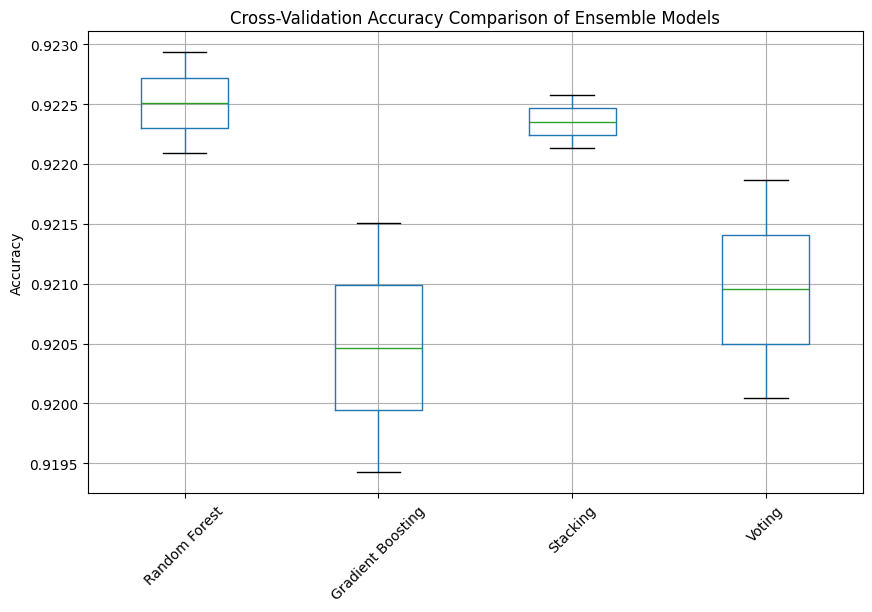

'It seems that the box plot shows perfect accuracy across all models,\nleading to a flat line around 1.0. This could happen if the models are\noverfitting or the dataset is too simple.'

In [14]:
import matplotlib.pyplot as plt

# Prepare results for visualization
import pandas as pd

#converted into a pandas DataFrame (results_df).
#This allows for easier manipulation and visualization.
results_df = pd.DataFrame(results)

# Plot box plot for model comparison
plt.figure(figsize=(10, 6))
results_df.boxplot()
plt.title("Cross-Validation Accuracy Comparison of Ensemble Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


'''It seems that the box plot shows perfect accuracy across all models,
leading to a flat line around 1.0. This could happen if the models are
overfitting or the dataset is too simple.'''


## Confusion Matrix for Each Model

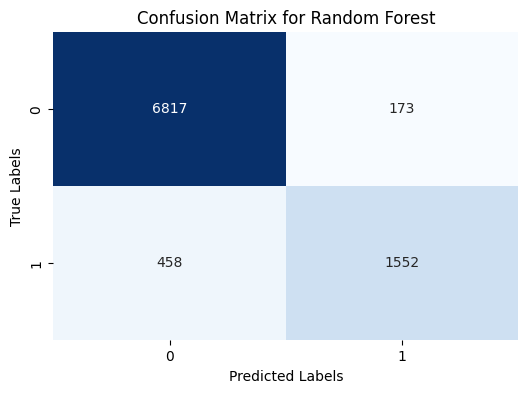

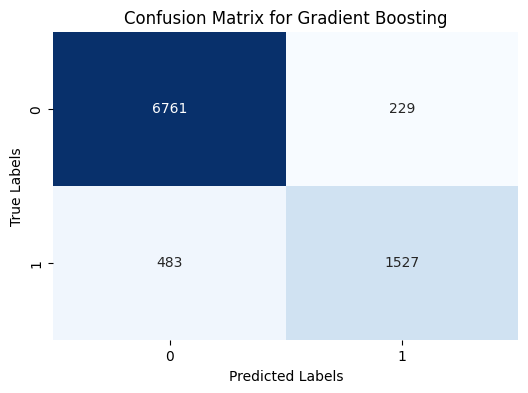

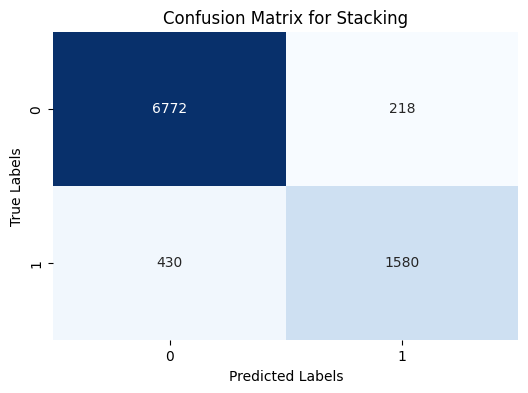

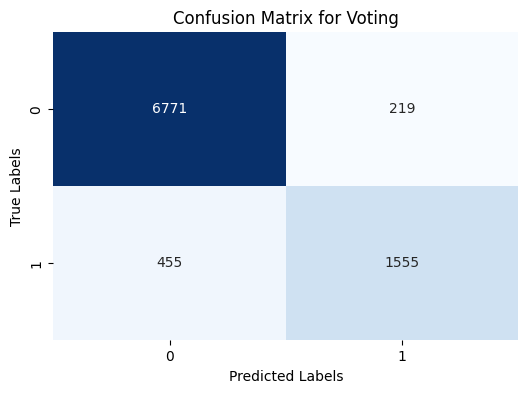

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fit each model on the training data and plot the confusion matrix for each
for model_name, model in models.items():
    # Fit the model and predict on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


## Precision and Recall for Each Model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Fit each model on the training data and calculate precision, recall, and F1-score
for model_name, model in models.items():
    # Fit the model and predict on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the metrics
    print(f"{model_name} Performance Metrics:")
    print(f" - Precision: {precision:.4f}")
    print(f" - Recall: {recall:.4f}")
    print(f" - F1 Score: {f1:.4f}\n")


Random Forest Performance Metrics:
 - Precision: 0.9287
 - Recall: 0.9299
 - F1 Score: 0.9279

Gradient Boosting Performance Metrics:
 - Precision: 0.9191
 - Recall: 0.9209
 - F1 Score: 0.9189



## Summary of Metrics

In [ ]:
# Collect all metrics in a DataFrame for summary
metrics_summary = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics_summary.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Convert to DataFrame
import pandas as pd
metrics_df = pd.DataFrame(metrics_summary)

# Display the summary
print("Model Performance Summary:")
metrics_df

# Explainable AI (XAI)

## Explaining Model Predictions Using SHAP
SHAP provides detailed insights into feature contributions for individual predictions and the overall model. We'll compute SHAP values for the Random Forest model as an example, but this approach can be extended to other models as well.

**How SHAP Works with Different Ensemble Models**

**Bagging Models (e.g., Random Forest)**

For bagging models, SHAP’s TreeExplainer efficiently computes SHAP values across each tree in the ensemble, averaging feature contributions to provide both global and local interpretability. This is useful for understanding which features are consistently important across all trees in a Random Forest.

**Boosting Models (e.g., Gradient Boosting, XGBoost)**

Boosting models like XGBoost use sequential training, where each iteration corrects the mistakes of the previous model. SHAP’s explanations reveal how feature importance evolves over iterations, highlighting which features the model focuses on as it learns. SHAP also captures the impact of feature interactions within the model’s complex structure.

**Stacking Models**

In stacking, where multiple base models feed into a meta-learner, SHAP can explain the contribution of each base model's predictions to the final outcome. Additionally, SHAP can be applied to each base model individually, revealing how each model uses features to make predictions, and how the meta-learner combines these predictions.

**Voting Classifier**

Although SHAP cannot directly interpret the aggregated predictions in a voting classifier, it can explain each base model individually, helping to understand how each model contributes to the ensemble’s overall decision. By comparing SHAP values across models, you can see how each one votes differently for features and identify potential model disagreements.

In [ ]:
import shap

# Use a subset of the data for SHAP to reduce computation time

#This code uses SHAP to explain the predictions of the Random Forest model
#on a subset of the test data.
X_sample = X_test.sample(100, random_state=42)


# Initialize SHAP explainer for the Random Forest model

#This initializes a TreeExplainer for the Random Forest model. The TreeExplainer is efficient
#for tree-based models (like Random Forest) and computes SHAP values to explain the output of
#individual predictions.
explainer = shap.TreeExplainer(models["Random Forest"])

#This computes the SHAP values for each feature in the sample data.
#The SHAP values represent how much each feature contributes to the difference between the prediction
#and the expected output (mean prediction).
shap_values = explainer.shap_values(X_sample)

# **illustrates the feature importance in terms of the average impact each feature has on the model's predictions**

In [ ]:
import numpy as np

# Calculate mean absolute SHAP values across all classes for each feature

#This step calculates the mean absolute SHAP value for each feature.

#The shap_values array contains the SHAP values for all instances in X_sample,
#and by taking the absolute value and averaging across all instances, we get
#an overall measure of each feature's contribution to the model's predictions.

mean_shap_values = np.mean([np.abs(sv) for sv in shap_values], axis=0)  # Resulting shape should be (100, 12) to match X_sample

# If mean_shap_values is (12, 5), take the mean across classes, resulting in a vector (12, )

#If there are multiple classes (for multi-class classification), this line computes the mean
#SHAP value across all classes, collapsing the results to a single value for each feature.

mean_shap_values = np.mean(mean_shap_values, axis=1)



# Repeat this vector to create a matrix that matches X_sample's shape

#This step repeats the mean_shap_values for each row in the sample data.
#This is necessary to create a shape that matches the original X_sample for visualization.
mean_shap_values_repeated = np.tile(mean_shap_values, (X_sample.shape[0], 1))


# Plot the summary plot with the repeated matrix
shap.summary_plot(mean_shap_values_repeated, X_sample, plot_type="bar", feature_names=X_sample.columns)


## Explaining Model Predictions Using LIME

In [ ]:
!pip install lime

# **LIME's LimeTabularExplainer provides a simple way to explain individual predictions of a model by approximating it locally with an interpretable model, highlighting the most influential features for that prediction.**

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
lime_explainer = LimeTabularExplainer(X_train.values, feature_names=data_X.columns, class_names=y.values, mode='classification')

# Choose a sample from the test set to explain
sample_index = 0 # Adjust to analyze a different sample

#Generate the Explanation
#This generates a local explanation for the chosen test instance using the Random Forest model’s predicted probabilities

exp = lime_explainer.explain_instance(X_test.values[sample_index], models["Random Forest"].predict_proba, num_features=10)
print(X_test.values[sample_index])
# Display the explanation
exp.show_in_notebook()
exp.show_in_notebook(show_table=True, show_all=False)


In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Choose a valid sample index
sample_index = 6  # Replace with a valid index, or use np.random.randint(0, len(X_test))


# Ensure feature_names and class_names are valid strings
feature_names = final_columns

# Ensure that class names in LIME are ordered the same way as the model output
class_names = [str(cls) for cls in sorted(y.unique())]  # Sorting the class labels to ensure correct order

# Initialize the LIME explainer with the corrected class names
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Generate the explanation again
exp = lime_explainer.explain_instance(
    X_test.values[sample_index],
    models["Random Forest"].predict_proba,
    num_features=10
)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)

# Print the selected sample's feature values
print("\n\nFeature values of the selected sample:")
print(X_test.values[sample_index])

# Get the actual class of the selected sample
actual_class = y_test.values[sample_index]
print(f"Actual class: {actual_class}")

# Get the predicted class of the selected sample
predicted_class = models["Random Forest"].predict(X_test.values[sample_index].reshape(1, -1))[0]
print(f"Predicted class: {predicted_class}")

# Get the predicted probabilities of the selected sample
predicted_probabilities = models["Random Forest"].predict_proba(X_test.values[sample_index].reshape(1, -1))[0]
print(f"Predicted probabilities: {predicted_probabilities}")


In [ ]:

#Positive or negative contributions of each feature to the predicted class

#(e.g., Battery Drain (mAh/day) has a high positive impact).